# EasyEdit Example with **ROME**
> Tutorial author: Peng Wang（<peng2001@zju.edu.cn>）
In this tutorial, we use `ROME` to edit `gpt2` model. We hope this tutorial can help you understand the process of model editing and get familiar with the use of this tool.

This tutorial uses `Python3`.

# Model Editing
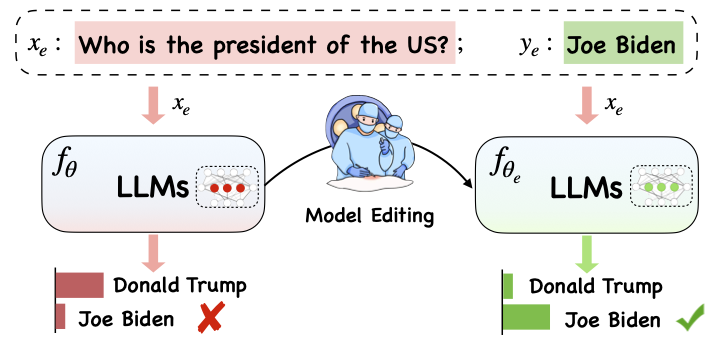

Deployed models may still make unpredictable errors. For example, Large Language Models (LLMs) notoriously *hallucinate*, *perpetuate bias*, and *factually decay*, so we should be able to adjust specific behaviors of pre-trained models.

**Model editing** aims to adjust an initial base model's $(f_\theta)$ behavior on the particular edit descriptor $[x_e, y_e]$, such as:
- $x_e$: "Who is the president of the US?
- $y_e$: "Joe Biden."

efficiently without influencing the model behavior on unrelated samples. The ultimate goal is to create an edited model$(f_\theta’)$.

# Editing Scope
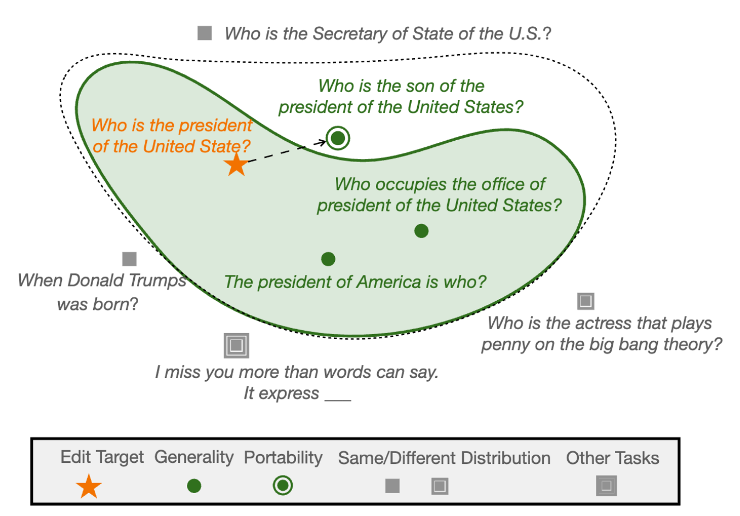

The model editing process generally impacts the predictions for a broad set of inputs **that are closely** associated with the edit example, called the **editing scope**.


A successful edit should adjust the model’s behavior within the editing scope while remaining unrelated inputs(as below formula).


$f_{\theta_{e}}(x) = \begin{cases}
y_e & \text{if } x \in I(x_e,y_e) \\
f_{\theta}(x) & \text{if } x \in O(x_e, y_e) \end{cases}$

In addition to this, the performance of model editing should be measured from multiple dimensions:

- `Reliability`: the success rate of editing with a given editing description
- `Generalization`: the success rate of editing **within** the editing scope
- `Locality`: whether the model's output changes after editing for unrelated inputs
- `Portability`: the success rate of editing for factual reasoning(one hop, synonym, one-to-one relation)
- `Efficiency`: time and memory consumption required during the editing process


# Method: **ROME**

Paper:[Locating and Editing Factual Associations in GPT](https://arxiv.org/abs/2202.05262)
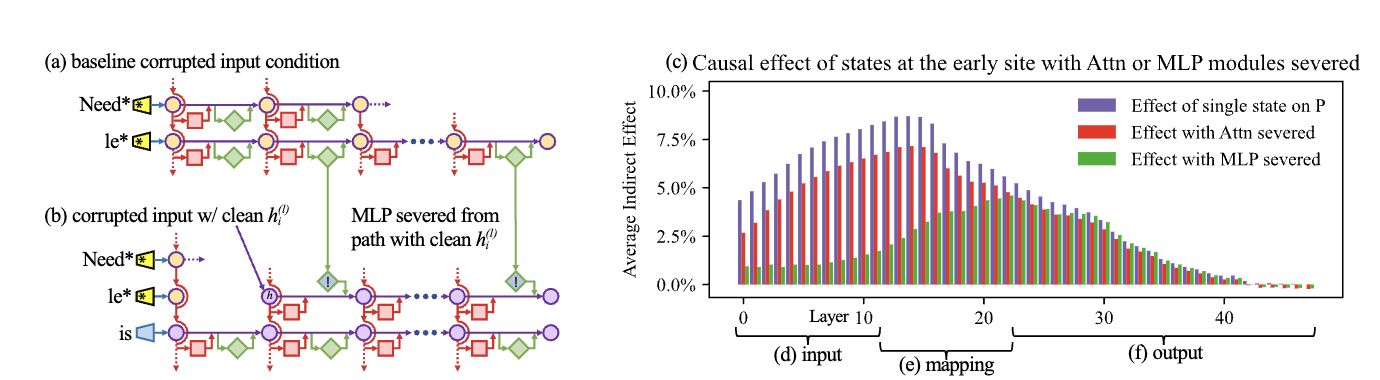

## Prepare the runtime environment

In [ ]:
## Clone Repo
# !git clone https://github.com/zjunlp/EasyEdit
%cd drive/MyDrive/Model-Editing/EasyEdit
!ls

/content/drive/MyDrive/Model-Editing/EasyEdit
Anaconda3-2023.03-1-Linux-x86_64.sh  figs	    logs
data				     get-pip.py     README.md
easyeditor			     globals.yml    requirements.txt
edit_memit_gpt2.py		     hparams	    scripts
edit.py				     hugging_cache
experiments			     LICENSE


In [ ]:
!apt-get install python3.9

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9-minimal
Suggested packages:
  python3.9-venv binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9 python3.9-minimal
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 5,030 kB of archives.
After this operation, 19.7 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-minimal amd64 3.9.17-1+focal1 [805 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9-minimal amd64 3.9.17-1+focal1 [2,064 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-stdlib amd64 3.9.17-1+focal1 [1,666 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9 amd64 3.

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3

There are 3 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.10   2         auto mode
  1            /usr/bin/python3.10   2         manual mode
  2            /usr/bin/python3.8    1         manual mode
  3            /usr/bin/python3.9    1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 3
update-alternatives: using /usr/bin/python3.9 to provide /usr/bin/python3 (python3) in manual mode


In [ ]:
!apt-get install python3-pip
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-pip python3-setuptools python3-wheel
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,389 kB of archives.
After this operation, 4,933 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python-pip-whl all 20.0.2-5ubuntu1.9 [1,805 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 python3-setuptools all 45.2.0-1ubuntu0.1 [330 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-wheel all 0.34.2-1ubuntu0.1 [23.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-pip all 20.0.2-5ubuntu1.9 [231 kB]
Fetched 2,389 kB in 0s (16

In [ ]:
!pip list

Package                   Version             
------------------------- --------------------
aiohttp                   3.8.1               
aiosignal                 1.2.0               
antlr4-python3-runtime    4.8                 
anyio                     3.7.1               
argon2-cffi               21.3.0              
argon2-cffi-bindings      21.2.0              
arrow                     1.2.3               
asttokens                 2.2.1               
async-timeout             4.0.2               
attrs                     23.1.0              
backcall                  0.2.0               
backports.csv             1.0.7               
base58                    2.1.1               
beautifulsoup4            4.12.2              
black                     22.1.0              
bleach                    6.0.0               
blessed                   1.20.0              
blis                      0.7.5               
boto3                     1.20.47             
botocore     

## Config Method Parameters
> xxx/gpt2.yaml (8GB is OK!)




```python
# For ROME hparams:

alg_name: "ROME"
model_name: "./hugging_cache/gpt2"
device: 0
layers: [9]
fact_token: "subject_last"
v_num_grad_steps: 23
v_lr: 5e-1
v_loss_layer: 11
v_weight_decay: 0.0015
clamp_norm_factor: 4
kl_factor: 0.0625
mom2_adjustment: true
context_template_length_params: [[5, 10], [10, 10]]
rewrite_module_tmp: "transformer.h.{}.mlp.c_proj"
layer_module_tmp: "transformer.h.{}"
mlp_module_tmp: "transformer.h.{}.mlp"
attn_module_tmp: "transformer.h.{}.attn"
ln_f_module: "transformer.ln_f"
lm_head_module: "transformer.wte"
mom2_dataset: "wikipedia"
mom2_n_samples: 1000
mom2_dtype: "float32"
```



In [ ]:
!pip install matplotlib
!pip install sentence_transformers

Processing /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f/sentence_transformers-2.2.2-py3-none-any.whl
     |████████████████████████████████| 6.0 MB 13.1 MB/s 
     |████████████████████████████████| 10.9 MB 62.8 MB/s 
     |████████████████████████████████| 1.3 MB 83.9 MB/s 
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
ERROR: torchvision 0.15.2 has requirement torch==2.0.1, but you'll have torch 1.10.2 which is incompatible.
ERROR: scikit-learn 1.3.0 has requirement joblib>=1.1.1, but you'll have joblib 1.1.0 which is incompatible.


## Import modules & Run

In [ ]:
%%bash
ls

python3.9

from easyeditor import BaseEditor
from easyeditor import ROMEHyperParams



prompts = ['Ray Charles, the',
            'Grant Hill is a professional',
            'The law in Ikaalinen declares the language'
            ]
ground_truth = ['piano',
                'basketball',
                'Finnish'
                ]
target_new = ['violin',
              'soccer',
              'Swedish'
              ]
subject = ['Ray Charles',
            'Grant Hill',
            'Ikaalinen'
            ]

hparams = ROMEHyperParams.from_hparams('./hparams/ROME/gpt2')
editor = BaseEditor.from_hparams(hparams)
metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    target_new=target_new,
    subject=subject,
    keep_original_weight=True
)

print(metrics)


print('*'*20)

from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('./hugging_cache/gpt2')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'
generation_prompts = [
    "Ray Charles, the",
    "The law in Ikaalinen declares the language"
]

model = GPT2LMHeadModel.from_pretrained('./hugging_cache/gpt2').to('cuda')
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=10
)

post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=10
)

Anaconda3-2023.03-1-Linux-x86_64.sh
data
easyeditor
edit_memit_gpt2.py
edit.py
experiments
figs
get-pip.py
globals.yml
hparams
hugging_cache
LICENSE
logs
README.md
requirements.txt
scripts
Executing ROME algorithm for the update: [Ray Charles, the] -> [violin]
Cached context templates ['{}', 'I was a little. {}', 'The first thing you. {}', 'A group of young. {}', 'The United States is. {}', 'The UESP. {}', '\nIn the early. {}', '\nA man was. {}', '"It\'s been. {}', 'The first time a. {}', '\n"The world. {}', '"The first thing I noticed about this is. {}', 'A man has been charged after his car was. {}', 'The first step in the process of making a. {}', '\nThe United Nations has warned that more than. {}', '\nA man was arrested after he was seen. {}', '"I am a little concerned that the government. {}', 'The first time I heard of a new book. {}', 'The U.S. Department of Justice announced. {}', 'I am a big fan of the game.. {}', '"The only way we can get out of. {}']
Computing left vector (

2023-07-11 13:05:44,332 - easyeditor.editors.editor - INFO - Instantiating model
07/11/2023 13:05:44 - INFO - easyeditor.editors.editor -   Instantiating model
  0%|          | 0/10 [00:00<?, ?it/s]
2023-07-11 13:06:13,671 - easyeditor.editors.editor - INFO - Execution 0 editing took 6.019999980926514
07/11/2023 13:06:13 - INFO - easyeditor.editors.editor -   Execution 0 editing took 6.019999980926514
2023-07-11 13:06:13,698 - easyeditor.editors.editor - INFO - Evaluation took 0.02671194076538086
07/11/2023 13:06:13 - INFO - easyeditor.editors.editor -   Evaluation took 0.02671194076538086
2023-07-11 13:06:13,698 - easyeditor.editors.editor - INFO - 0 editing: Ray Charles, the -> violin  
 {'case_id': 0, 'time': 6.019999980926514, 'post': {'rewrite_acc': 0.5, 'locality': {}, 'portability': {}}, 'pre': {'rewrite_acc': 0.0, 'portability': {}}}
07/11/2023 13:06:13 - INFO - easyeditor.editors.editor -   0 editing: Ray Charles, the -> violin  
 {'case_id': 0, 'time': 6.019999980926514, 'pos

In [ ]:
%%bash
ls

python3.9

from easyeditor import BaseEditor
from easyeditor import ROMEHyperParams



prompts = ['Ray Charles, the',
            'Grant Hill is a professional',
            'The law in Ikaalinen declares the language'
            ]
ground_truth = ['piano',
                'basketball',
                'Finnish'
                ]
target_new = ['violin',
              'soccer',
              'Swedish'
              ]
subject = ['Ray Charles',
            'Grant Hill',
            'Ikaalinen'
            ]

hparams = ROMEHyperParams.from_hparams('./hparams/ROME/gpt2')
editor = BaseEditor.from_hparams(hparams)
metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    target_new=target_new,
    subject=subject,
    keep_original_weight=False
)

print('*'*100)

from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('./hugging_cache/gpt2')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'
generation_prompts = [
    "Ray Charles, the",
    "The law in Ikaalinen declares the language"
]

model = GPT2LMHeadModel.from_pretrained('./hugging_cache/gpt2').to('cuda')
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_new_tokens=3
)
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_new_tokens=3
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])
exit()

Anaconda3-2023.03-1-Linux-x86_64.sh
data
easyeditor
edit_memit_gpt2.py
edit.py
experiments
figs
get-pip.py
globals.yml
hparams
hugging_cache
LICENSE
logs
README.md
requirements.txt
scripts
Executing ROME algorithm for the update: [Ray Charles, the] -> [violin]
Cached context templates ['{}', '\nIn the wake. {}', '\nIn the early. {}', '\nA former U. {}', 'The first thing to. {}', 'I am not going. {}', '"I think that. {}', 'The U.S. {}', 'A new report by. {}', '\nThe United States. {}', '\nThe first thing. {}', '\nThe U.S. government has been. {}', '"This is the biggest mistake that has been. {}', '\nIn the early hours of Tuesday afternoon,. {}', '\nThe U.S. Department of Agriculture. {}', '\nA man is facing murder charges for allegedly. {}', '"We are all in it for one thing. {}', 'The following is a list of the top 10. {}', '\nA former police officer has pleaded guilty to. {}', '"The first step is to get a sense. {}', "I've been working at a company that's. {}"]
Computing left vector (u

2023-07-11 13:35:03,757 - easyeditor.editors.editor - INFO - Instantiating model
07/11/2023 13:35:03 - INFO - easyeditor.editors.editor -   Instantiating model
  0%|          | 0/10 [00:00<?, ?it/s]
2023-07-11 13:35:21,410 - easyeditor.editors.editor - INFO - Execution 0 editing took 2.7406694889068604
07/11/2023 13:35:21 - INFO - easyeditor.editors.editor -   Execution 0 editing took 2.7406694889068604
2023-07-11 13:35:21,486 - easyeditor.editors.editor - INFO - Evaluation took 0.07390546798706055
07/11/2023 13:35:21 - INFO - easyeditor.editors.editor -   Evaluation took 0.07390546798706055
2023-07-11 13:35:21,487 - easyeditor.editors.editor - INFO - 0 editing: Ray Charles, the -> violin  
 {'case_id': 0, 'time': 2.7406694889068604, 'post': {'rewrite_acc': 0.5, 'locality': {}, 'portability': {}}, 'pre': {'rewrite_acc': 0.5, 'portability': {}}}
07/11/2023 13:35:21 - INFO - easyeditor.editors.editor -   0 editing: Ray Charles, the -> violin  
 {'case_id': 0, 'time': 2.7406694889068604, 